In [1]:
import re

def detect_all_eng(text):
    if not isinstance(text, str):
        return ''
    
    _text = re.sub(r'[0-9]', '', text)
    
    if re.fullmatch(r"[A-Za-z\s]*", _text):
        return ''
    else:
        return text

In [2]:
def remove_invalid_reviews(df, column_name):
    try:
        filtered_df = df[df[column_name].apply(lambda text: isinstance(text, str) and text.strip() != '')]
        return filtered_df
    except Exception as e:
        print(f"Error: {e}")
        return df

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 예측 수행 함수
def predict(texts):
    model = AutoModelForSequenceClassification.from_pretrained("./hate_speech_model")
    tokenizer = AutoTokenizer.from_pretrained("./hate_speech_model")

    # 입력 데이터 토크나이징 및 디바이스 이동
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt",
        add_special_tokens=True,
        stride=32,
    )

    # 모델 추론
    with torch.no_grad():  # 예측 시에는 Gradient 계산 비활성화
        outputs = model(
            input_ids=encodings["input_ids"],
            attention_mask=encodings["attention_mask"]
        )
    logits = outputs.logits

    probabilities = torch.softmax(logits, dim=-1).numpy()

    # 클래스와 확률 추출
    predictions = []
    for text, prob in zip(texts, probabilities):
        max_prob = max(prob)  # 가장 높은 확률
        max_label = prob.argmax()  # 가장 높은 확률의 클래스(숫자)
        predictions.append({"text": text, "label": max_label, "probability": max_prob})

    return predictions

# 모델 정확도

In [4]:
import pandas as pd

# 입력 데이터
labeled = pd.read_csv('./Dataset/output_overwatch_labeled_by_me.csv')

# 영어 리뷰 삭제
labeled['review'] = labeled['review'].apply(detect_all_eng)

In [5]:
labeled_texts = labeled['review'].tolist()
hate = labeled['hate'].tolist()
voted_up = labeled['voted_up'].tolist()

In [6]:
# 원본 예측
predictions = predict(labeled_texts)
print("Predictions:", predictions[:5])

Predictions: [{'text': '핵 잡아', 'label': 8, 'probability': 0.99730444}, {'text': '진짜 지금가지 해본 게임 중 가장 최악이다', 'label': 8, 'probability': 0.9960257}, {'text': '거이 준상이 수능 점수', 'label': 8, 'probability': 0.9978613}, {'text': '정신병 걸림', 'label': 8, 'probability': 0.9966826}, {'text': '진짜 개좆같네 팀원들이 싹다 장애인 개새끼들 아오 존나 패버리고 싶다 시발 키리코 개쌔끼는 지가 딜런줄 알아 병신새끼가 그ㅜ래놓고 힐 689 개새끼 시발럼 아오 로드호그 개쌔끼 킬 어시 뒤짐 개쌔끼 진짜 지금 생각해보니까 존나 빡치네 개쌔기들아 보고있냐 시발', 'label': 3, 'probability': 0.9835644}]


In [7]:
# 욕으로 판단한 개수
count = 0

for result in predictions:
    if result['label'] != 8:
        count += 1
        
print(f'전체 리뷰 수: {len(predictions)}, 욕으로 판단한 개수: {count}개')

전체 리뷰 수: 1285, 욕으로 판단한 개수: 248개


In [8]:
result = []
probability = []

for p in predictions:
    result.append(p['label'])
    probability.append(p['probability'])

Performance Metrics:
Accuracy: 0.96
Precision (Macro): 0.67
Recall (Macro): 0.70
F1 Score (Macro): 0.63


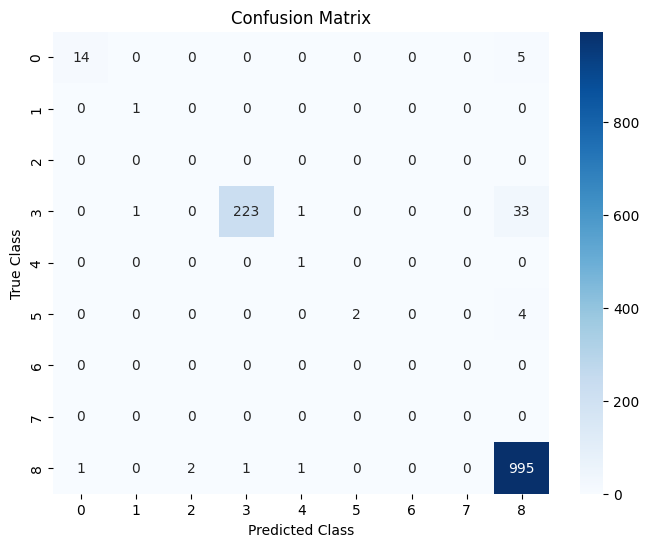


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         0
           3       1.00      0.86      0.93       258
           4       0.33      1.00      0.50         1
           5       1.00      0.33      0.50         6
           8       0.96      0.99      0.98      1000

    accuracy                           0.96      1285
   macro avg       0.67      0.70      0.63      1285
weighted avg       0.97      0.96      0.96      1285



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns

# 1. 정확도, Precision, Recall, F1 Score 계산
accuracy = accuracy_score(hate, result)
macro_precision = precision_score(hate, result, average="macro", zero_division=0)
macro_recall = recall_score(hate, result, average="macro", zero_division=0)
macro_f1 = f1_score(hate, result, average="macro", zero_division=0)

print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Macro): {macro_precision:.2f}")
print(f"Recall (Macro): {macro_recall:.2f}")
print(f"F1 Score (Macro): {macro_f1:.2f}")

# 2. 혼동 행렬 계산 및 시각화
# 모든 클래스 (0부터 8까지 명시적으로 지정)
all_classes = np.arange(9)

# 혼동 행렬 계산 (labels로 모든 클래스 포함)
conf_matrix = confusion_matrix(hate, result, labels=all_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=all_classes, 
    yticklabels=all_classes
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# 3. Classification Report 출력
print("\nClassification Report:")
print(classification_report(hate, result, zero_division=0))

In [10]:
lst = []

for i, result in enumerate(predictions):
    lst.append({
        'review': result['text'],
        'voted_up': voted_up[i],
        'hate': hate[i],
        'hate_1': result['label']
    })
    
df = pd.DataFrame(lst)

# 비속어 데이터셋으로 필터링 하기

In [11]:
import pandas as pd

badwords = pd.read_csv('./Dataset/badwords.csv')['badwords'].dropna().tolist()

In [12]:
import re

def filtering_with_csv(text):
    if not isinstance(text, str):
        return ''
    
    badwords_pattern = re.compile(r'\b(' + '|'.join(map(re.escape, badwords)) + r')\b')
    filtered_text = badwords_pattern.sub('', text)

    return filtered_text

In [13]:
df['review'] = df['review'].apply(filtering_with_csv)

texts = df['review'].tolist()
hate = df['hate_1'].tolist()

In [14]:
predictions = predict(texts)
print("Predictions:", predictions[:5])

Predictions: [{'text': '핵 잡아', 'label': 8, 'probability': 0.99730444}, {'text': '진짜 지금가지 해본 게임 중 가장 최악이다', 'label': 8, 'probability': 0.9960257}, {'text': '거이 준상이 수능 점수', 'label': 8, 'probability': 0.9978613}, {'text': '정신병 걸림', 'label': 8, 'probability': 0.9966826}, {'text': '진짜 개좆같네 팀원들이 싹다   아오  패버리고 싶다  키리코 개쌔끼는 지가 딜런줄 알아  그ㅜ래놓고 힐 689   아오 로드호그  킬 어시 뒤짐  진짜 지금 생각해보니까  빡치네  보고있냐 ', 'label': 3, 'probability': 0.9840604}]


In [15]:
diff = 0

for i, result in enumerate(predictions):
    if result['label'] != hate[i]:
        print(f"문장: {result['text']}")
        print(f"기존 클래스: {hate[i]}, 판단된 클래스: {result['label']}, 확률: {result['probability']:.2f}")
        print()
        diff += 1
        
print(f"기존과 예측이 달라진 개수: {diff}")

문장: 
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장:   재미없는 게임 애들이 하는지 1도 이해가 안감
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장: 옵치1 역할 고정 없을 때부터 탱2딜2힐2 지금 1탱 2딜 2힐까지 왔는데 몇년 변한게 있냐 캐릭 출시를 많이 했어 맵을 더 만들었어 뭘 했어 만든다고 무한 정켄슈타인 돌리고 나온게 똥쓰레기임 그렇게 얘기하던 PVE는 어디감 그거로 스토리 풀어준다면서 이럴거면 개발 함 몇년 째 요원 소집만 하는 유인원   안후림 예전엔 렙업하면 상자 줘서 그거로 무료 스프레이 스킨 음성 얻는 맛 있었고 크레딧으로 상깡 가능했음 유료로 옵치 주고 시작했지만 가챠 못 참아서 질렀었음 근데 지금 무조건 정가임 스킨 하나에 31000인데 이걸 돈 주고 병신임 팀포가 그래픽만 좋았어도 옵치는 뒤졌을게 분명함 병신겜
기존 클래스: 3, 판단된 클래스: 8, 확률: 0.88

문장: 정말 뭐같은 팀 매칭시스템만 정말 좋을 게임 제재좀 확실히좀 해주세요  화나니깐
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장:  플레이 할 마다 컨텐츠 다운로드는 계속 시키는거냐
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장:  봇 패작 잡지도 않음
기존 클래스: 0, 판단된 클래스: 8, 확률: 0.99

문장:  시작이 앉도ㅔㅁ
기존 클래스: 3, 판단된 클래스: 8, 확률: 0.95

문장: 
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장:  노잼이네 힐러만하면 자꾸나만죽이는데 잼민이는 겜하지마삼
기존 클래스: 3, 판단된 클래스: 8, 확률: 0.99

문장:  껴있으면 게임 난이도 폭증
기존 클래스: 0, 판단된 클래스: 8, 확률: 1.00

문장: 로그인부터 
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장: 탱커는 부담감 높다고 개 징징 딜러는  내가 다 해줬는데 다 뭐함 뻔뻔 힐러는 오빠들 뒤좀 봐줘하면서 절대로 픽 안바꾸고 지 상황 

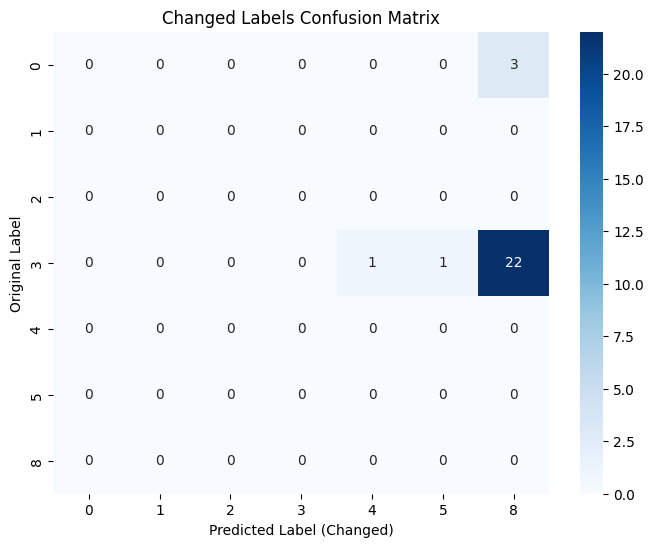

In [16]:
# 변경된 결과를 저장
changed_results = []

for i, result in enumerate(predictions):
    if result["label"] != hate[i]:
        changed_results.append((hate[i], result["label"]))

# 모든 가능한 라벨을 추출
all_labels = sorted(set(hate) | {r["label"] for r in predictions})

# 혼동 행렬 데이터 초기화
matrix = pd.DataFrame(0, index=all_labels, columns=all_labels)

# 변경된 결과를 혼동 행렬에 기록
for original, changed in changed_results:
    matrix.at[original, changed] += 1

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
plt.title("Changed Labels Confusion Matrix")
plt.xlabel("Predicted Label (Changed)")
plt.ylabel("Original Label")
plt.show()

In [17]:
lst = []

for i, result in enumerate(predictions):
    lst.append(result['label'])

df['hate_2'] = lst

# 정규식을 이용한 두 번째 필터링

In [18]:
import re

CURSEWORD_PATTERN = re.compile(r'[시씨씪슈쓔쉬쉽쒸쓉](?:[0-9]*|[0-9]+ *)[바발벌빠빡빨뻘파팔펄]|[섊좆좇졷좄좃좉졽썅춍봊]|[ㅈ조][0-9]*까|ㅅㅣㅂㅏㄹ?|ㅂ[0-9]*ㅅ|[ㅄᄲᇪᄺᄡᄣᄦᇠ]|[ㅅㅆᄴ][0-9]*[ㄲㅅㅆᄴㅂ]|[존좉좇][0-9 ]*나|[자보][0-9]+지|보빨|[봊봋봇봈볻봁봍] *[빨이]|[후훚훐훛훋훗훘훟훝훑][장앙]|[엠앰]창|애[미비]|애자|[가-탏탑-힣]색기|(?:[샊샛세쉐쉑쉨쉒객갞갟갯갰갴겍겎겏겤곅곆곇곗곘곜걕걖걗걧걨걬] *[끼키퀴])|새 *[기키퀴]|[병븅][0-9]*[신딱딲]|미친[가-닣닥-힣]|[믿밑]힌|[염옘][0-9]*병|[샊샛샜샠섹섺셋셌셐셱솃솄솈섁섂섓섔섘]기|[섹섺섻쎅쎆쎇쎽쎾쎿섁섂섃썍썎썏][스쓰]|[지야][0-9]*랄|니[애에]미|갈[0-9]*보[^가-힣]|[뻐뻑뻒뻙뻨][0-9]*[뀨큐킹낑)|꼬[0-9]*추|곧[0-9]*휴|[가-힣]슬아치|자[0-9]*박꼼|빨통|[사싸](?:이코|가지|[0-9]*까시)|육[0-9]*시[랄럴]|육[0-9]*실[알얼할헐]|즐[^가-힣]|찌[0-9]*(?:질이|랭이)|찐[0-9]*따|찐[0-9]*찌버거|창[녀놈]|[가-힣]{2,}충[^가-힣]|[가-힣]{2,}츙|부녀자|화냥년|환[양향]년|호[0-9]*[구모]|조[선센][징]|조센|[쪼쪽쪾](?:[발빨]이|[바빠]리)|盧|무현|찌끄[레래]기|(?:하악){2,}|하[앍앜]|[낭당랑앙항남담람암함][ ]?[가-힣]+[띠찌]|느[금급]마|文在|在寅|(?<=[^\n])[家哥]|속냐|[tT]l[qQ]kf|Wls|[ㅂ]신|[ㅅ]발|[ㅈ]밥|장애인')  # 해당 정규식 전체를 복사해서 붙여넣으세요

def filtering_with_re_ex(text):
    if not isinstance(text, str):
        return ''
    
    filtered_text = CURSEWORD_PATTERN.sub('', text)
    return filtered_text

In [19]:
df['review'] = df['review'].apply(filtering_with_re_ex)

texts = df['review'].tolist()
hate = df['hate_2'].tolist()

In [20]:
predictions = predict(texts)
print("Predictions:", predictions[:5])

Predictions: [{'text': '핵 잡아', 'label': 8, 'probability': 0.99730444}, {'text': '진짜 지금가지 해본 게임 중 가장 최악이다', 'label': 8, 'probability': 0.9960257}, {'text': '거이 준상이 수능 점수', 'label': 8, 'probability': 0.9978613}, {'text': '정신병 걸림', 'label': 8, 'probability': 0.9966826}, {'text': '진짜 개같네 팀원들이 싹다   아오  패버리고 싶다  키리코 개쌔끼는 지가 딜런줄 알아  그ㅜ래놓고 힐 689   아오 로드호그  킬 어시 뒤짐  진짜 지금 생각해보니까  빡치네  보고있냐 ', 'label': 3, 'probability': 0.97777575}]


In [21]:
diff = 0
for i, result in enumerate(predictions):
    if result['label'] != hate[i]:
        print(f"문장: {result['text']}")
        print(f"기존 클래스: {hate[i]}, 판단된 클래스: {result['label']}, 확률: {result['probability']:.2f}")
        print()
        diff += 1
        
print(f"기존과 예측이 달라진 개수: {diff}")

문장: 그냥 게임
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장: 뒤진 겜 힐러가 개  딜러보다 쎄면 누가 딜러함 롤처럼 딜은 딜만 힐은 힐만 탱은 탱만하게 해야지  뭐 아나가 힐 안하고 딜쳐하고 모이라가 딜쳐하고 겜 할바엔 폰허브 솔져 리퍼 게이나 보러가셈 Worst fxxing game ever Rather than playing this game youre better off watching soldier and reaper gay  uploaded to pxxxhub
기존 클래스: 3, 판단된 클래스: 8, 확률: 0.92

문장: 게임
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장: 들아 총이 30m거리에서 피해감소 돠는게 말이 되냐
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장: 게임 빠대 탈주 페널티 없애라
기존 클래스: 3, 판단된 클래스: 8, 확률: 0.97

문장: 애들 패치를 하면 누구는 각성하는데 누군는 이 되는거냐
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장: 버워치
기존 클래스: 3, 판단된 클래스: 8, 확률: 1.00

문장: 개발자 들아 하다하다 이제 방벽 관통 밖에 없는 라붕이를 건드리냐 개들아 내 라마트라 돌려내 할꺼면 라마 응징 대미지 자체를 2배로 하던가 아님 라인과 정커퀸도 방벽 못 뚫게 막아  개발진들아
기존 클래스: 3, 판단된 클래스: 8, 확률: 0.94

문장: 얘네가 뭔잘못을 했냐 신규 모드라면서 팀포 그대로 배낀 PVE를 만들겠다고 했다가 취소라도 했냐 트레일러도 팀포mvm 그대로 배끼기라도 했냐 한정스킨이라고 못쳐박다가 갑자기 상점에 돈주고 사게 쳐내기라도 했냐솔까 근데 이건 난 좋음ㅋㅋ 신캐들을 무조건 배패로 쳐풀어서 같게 하기라도 했냐 별 없는 모드는 쳐내면서 하나무라를 없애기라도 했냐 후 억까는 자제해주세요 이고 할만함
기존 클래스: 3, 판단된 클래스: 8, 확률: 0.93

문장: 겜 친구랑 하는거 하지마세요
기존 클래스: 

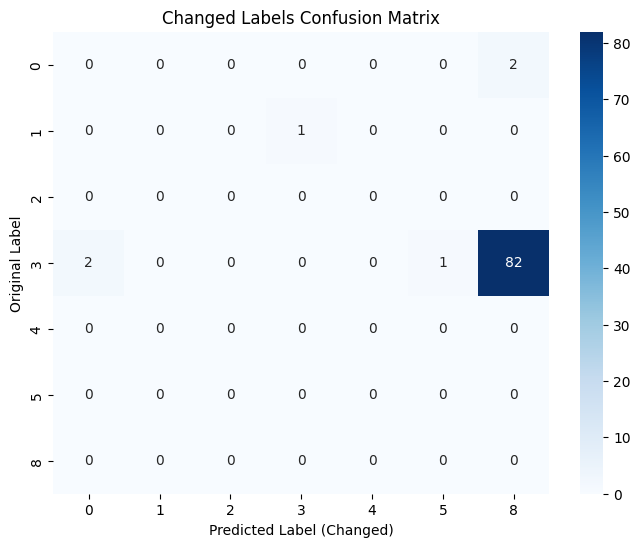

In [22]:
# 변경된 결과를 저장
changed_results = []

for i, result in enumerate(predictions):
    if result["label"] != hate[i]:
        changed_results.append((hate[i], result["label"]))

# 모든 가능한 라벨을 추출
all_labels = sorted(set(hate) | {r["label"] for r in predictions})

# 혼동 행렬 데이터 초기화
matrix = pd.DataFrame(0, index=all_labels, columns=all_labels)

# 변경된 결과를 혼동 행렬에 기록
for original, changed in changed_results:
    matrix.at[original, changed] += 1

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
plt.title("Changed Labels Confusion Matrix")
plt.xlabel("Predicted Label (Changed)")
plt.ylabel("Original Label")
plt.show()

In [23]:
lst = []
plst = []

for i, result in enumerate(predictions):
    lst.append(result['label'])
    plst.append(result['probability'])

df['hate_3'] = lst
df['probability_3'] = plst

In [25]:
df.head()

,review,voted_up,hate,hate_1,hate_2,hate_3,probability_3
0,핵 잡아,False,8,8,8,8,0.997304
1,진짜 지금가지 해본 게임 중 가장 최악이다,False,8,8,8,8,0.996026
2,거이 준상이 수능 점수,False,8,8,8,8,0.997861
3,정신병 걸림,False,8,8,8,8,0.996683
4,진짜 개같네 팀원들이 싹다 아오 패버리고 싶다 키리코 개쌔끼는 지가 딜런줄 ...,False,3,3,3,3,0.977776


In [34]:
filtered_df = df[(df['hate_3'] != 8) & (df['probability_3'] >= 0.6) & (df['probability_3'] < 0.9)]

In [35]:
filtered_df

,review,voted_up,hate,hate_1,hate_2,hate_3,probability_3
23,핵좀 처 빨리빨리 잡아라 들아,False,3,3,3,3,0.854550
82,탈출은 지능순입니다 유저 수준이 너무 떨어지고 게임도 다 망해서 유저가 없어요 항상...,False,0,0,0,0,0.729171
100,병x같은 운영이 게임 말아 먹은 케이스 게임을 하고 나면 블리자드 망했으면 좋겠다는...,False,3,3,3,3,0.848408
101,게임이 안 좋은 점 업데이트 이후 추천 레벨 3이상 사설게임 만들 수 오버워치1 같...,False,3,3,3,3,0.800121
218,로그인 과정 개 복잡함 예전 생각나서 해봤는데 ㅈ노잼,False,3,3,3,3,0.776276
338,게임 수준 압도적으로 부정적 평판 압도적으로 부정적 게임사 압도적으로 부정적 운영 ...,False,3,3,3,3,0.892174
398,비응신 유저들의 정치질 능력 게임사의 엄청난 운영 개똥겜,False,3,3,3,3,0.862396
478,h1 만에 게임 하려면 늦은시간에 돌리지 마라 h1 친구랑 돌리는데 짱ㄲㅐ 새끼들 ...,False,0,0,0,0,0.880631
488,한판 이기면 귀신같이 처발리는 매칭만 뜸 한판하면 하기 싫어지는 겜,False,3,3,3,3,0.652432
500,느그옵 느그옵 퇴물이네,False,3,3,4,4,0.667042


In [36]:
filtered_df.to_csv('./Dataset/filtered_output_overwatch.csv', index=False)

In [37]:
clean_df = df[df['hate_3'] == 8]

In [38]:
clean_df

,review,voted_up,hate,hate_1,hate_2,hate_3,probability_3
0,핵 잡아,False,8,8,8,8,0.997304
1,진짜 지금가지 해본 게임 중 가장 최악이다,False,8,8,8,8,0.996026
2,거이 준상이 수능 점수,False,8,8,8,8,0.997861
3,정신병 걸림,False,8,8,8,8,0.996683
5,,False,3,3,8,8,0.997898
...,...,...,...,...,...,...,...
1276,계정연동어떻게하냐 블리자드앱을 설치하라는것가 자꾸 큐알코드뜨고 찍어도 안되고,False,3,3,8,8,0.997571
1279,,False,3,8,8,8,0.997898
1280,오버워치가 갓겜 맞죠 아니야,False,8,8,8,8,0.995526
1281,가끔하기 좋음,True,8,8,8,8,0.998333


In [40]:
clean_df = remove_invalid_reviews(clean_df, 'review')

In [41]:
clean_df.shape

(1133, 7)

In [39]:
def reduce_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

In [42]:
clean_df = clean_df[['review', 'voted_up']]

clean_df['review'] = clean_df['review'].apply(reduce_multiple_spaces)

In [43]:
clean_df.to_csv('./Dataset/clean_output_overwatch.csv', index=False)